In [180]:
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
from PIL import Image
import scipy.sparse as sp
import time
import itertools
import scipy
import cvxpy as cp
import random
import matplotlib
import math
def create_array(orig_array, percentage):
    # Compute the number of unique rows we'll use
    num_rows = int(orig_array.shape[0] *percentage)
    
    # If num_rows is zero, we should at least select one row.
    num_rows = max(1, num_rows)
    
    # Randomly select 'num_rows' row indices without replacement
    unique_indices = np.random.choice(orig_array.shape[0], size=num_rows, replace=False)

    # Select the unique rows from the original array
    unique_rows = orig_array[unique_indices, :]
    
    # Now, we'll need to repeat these rows to fill the new array
    num_repeats = int(np.ceil(orig_array.shape[0] / float(num_rows)))

    # Repeat the unique rows to create a new array
    new_array = np.repeat(unique_rows, num_repeats, axis=0)
    
    # Make sure the new array has the same number of rows as the original array
    new_array = new_array[:orig_array.shape[0], :]
    
    return new_array

class Genetic_Algorithm:
    def __init__(self, beta, img_list, turnover_rate, parent_to_children, random_selection, parent_changed):
        
        self.beta = beta
        self.N = img_list[0].shape[0]
        self.dim = len(img_list[0].shape)
        self.imgs = [img.flatten() for img in img_list]
        self.b_eq = np.concatenate(self.imgs)
        self.non_zero_indices = []
        self.n_imgs = len(self.imgs)
        self.turnover_rate = turnover_rate
        self.parent_to_children = parent_to_children
        self.random_selection = random_selection
        self.parent_changed = parent_changed
        
        start = time.time()
        print("initializing omega...")
        self.current_gamma, self.active_indices = self.initialize_omega()
        print("omega initialized in %5.3f. s" %(time.time()-start))
        
        start = time.time()
        print("initializing cost vector...")
        self.current_cost_vector = self.get_cost(self.active_indices)
        print("cost vector initialized in %5.3f. s" %(time.time()-start))
       
        start = time.time()
        print("initializing full model...")
        self.current_gamma, self.constraints_RMP, self.current_kantorovich = self.initialize_model()
        print("full model initialized in %5.3f. s" %(time.time()-start))

        #stats
        self.cost = []
        self.time_child = []
        self.children_sampled = []
        self.time_model = []
        self.len_children = []
        self.n_children = []
        
    def initialize_omega(self):
        #the north west rule is used to initialise omega
        #we start with the first pixel of each image
        indices = np.zeros(self.n_imgs)
        omega = [indices.copy()]
        b = np.array([img[0] for img in self.imgs])

        current_gamma = [np.min(b)]
        while np.min(indices) < self.N**self.dim-1:
            gamma = np.min(b)
            if gamma < 0:
                print("error")
                break
            b-=gamma
            for i in range(self.n_imgs):
                if indices[i]==self.N**self.dim-1:
                    continue
                if math.isclose(b[i],0,abs_tol=1e-14):
                    indices[i]+=1
                    b[i] = self.imgs[i][indices[i].astype('int')]
            omega.append(indices.copy())
            current_gamma.append(gamma)
        
        return np.array(current_gamma), np.array(omega).astype('int')
        
    def initialize_model(self):
        indices_row = np.array([])
        indices_col = np.array([])
        for i in range(self.n_imgs):
            for indices in range(self.N**self.dim):
                gamma_indices = np.where(self.active_indices.transpose()[i] == indices)[0]
                indices_row = np.concatenate((indices_row, gamma_indices))
                indices_col = np.concatenate((indices_col, np.ones(len(gamma_indices))*(indices+i*self.N**self.dim)))

        A_eq = sp.csr_matrix((np.ones(len(indices_col)), (indices_col, indices_row)), shape=( self.N**self.dim*self.n_imgs, len(self.active_indices)))
        
        gamma = cp.Variable(len(self.current_cost_vector))
        
        objective = cp.Minimize(self.current_cost_vector @ gamma)
       
        constraints = [A_eq@gamma==self.b_eq, gamma >= 0]
        prob = cp.Problem(objective, constraints)
        gamma.value = self.current_gamma
        prob.solve(warm_start=True, solver=cp.GUROBI)
        
        primal_solution = gamma.value
        dual_solution = -constraints[0].dual_value
        return primal_solution, A_eq, dual_solution

    def barycentric_distance(self, indices_list):
        # mean squared deviation from the classical barycenter of the xi
        #rescale x and y to be in [0,1]
        indices_list=indices_list/self.N
        barycenter = np.sum(indices_list, axis=0)/self.n_imgs
        barycenter_cost = np.sum([np.sum((x - barycenter) ** 2, axis=0)/self.n_imgs for x in indices_list], axis=0)
        return barycenter_cost

    def get_cost(self, vector):
        #for each pair of active pixels, compute the cost of moving the first pixel to the second
        indices_list = []
        for i in range(self.n_imgs):
            indices_list.append(np.array(np.unravel_index(vector.transpose()[i], tuple([self.N for i in range(self.dim)]))))
        cost_vector = self.barycentric_distance(np.array(indices_list))
        return cost_vector

    def compute_gain(self, cost, children):
        gain = np.sum([self.current_kantorovich[i*(self.N**self.dim):(i+1)*(self.N**self.dim)][children.transpose()[i]] for i in range(self.n_imgs)])-cost
        return gain

    def find_best_child(self):
        parent = self.non_zero_indices.copy().transpose()
       
        parent = create_array(parent, self.parent_to_children)
       
        index = random.sample(range(0, self.n_imgs), self.parent_changed)
        parent[index] = np.random.randint(0, self.N**self.dim, size=len(parent[1]))
        
        children = parent.copy().transpose()
        
        gain = self.compute_gain(self.get_cost(children), children) 
        best_children = children[np.where(gain > 0)[0]]
        
        #now take the best turnover_rate% or just some random turnover_rate
        if self.random_selection:                  
            best_children = children[np.argsort(gain)[-int(best_children.shape[0]*turnover_rate):]]
        else:
            chosen_children = np.random.choice(best_children.shape[0], size=int(best_children.shape[0]*turnover_rate), replace=False)
            best_children = best_children[chosen_children]
       
        return best_children

    
    def get_single_cost(self, child):
        indices = np.array([np.array(np.unravel_index(child[0], tuple([self.N for i in range(self.dim)]))) for i in range(self.n_imgs)])
        return self.barycentric_distance(indices)
    
    def run(self, max_iter, max_sample, max_runtime):
        start_runtime = time.time()
        for _ in tqdm(range(max_iter)):
            if time.time() - start_runtime > max_runtime:
                break
            start = time.time()
            self.non_zero_indices = self.active_indices[np.nonzero(self.current_gamma)]
            sample = 0
            #divide the non zero indices into chunks of size chunk_size
            best_children = self.find_best_child()
            while best_children.shape[0] == 0 and sample < max_sample:
                sample += len(self.non_zero_indices)
                best_children = self.find_best_child()
            
            self.children_sampled.append(sample)
            self.time_child.append(time.time() - start)
            self.n_children.append(self.active_indices.shape[0])
            self.current_cost_vector = np.append(self.current_cost_vector, self.get_cost(best_children))
            self.current_gamma = np.append(self.current_gamma, np.zeros(best_children.shape[0]))
            for child in best_children:
                 self.active_indices = np.vstack((self.active_indices, child))
                 children = self.active_indices[-1]
                 A_col = np.zeros((self.N**self.dim)*self.n_imgs)
                 children_idx = [i*(self.N**self.dim)+children[i] for i in range(self.n_imgs)]
                 A_col[children_idx] = 1
                 self.constraints_RMP = sp.hstack((self.constraints_RMP, A_col.reshape(-1,1)))

            if self.active_indices.shape[0] > int(self.beta*((self.N**self.dim)*self.n_imgs)):
                if self.beta>2:
                    remove_value = self.beta-1
                else:
                    remove_value = 1
                zero_indices = np.where(self.current_gamma == 0)[0][:int(remove_value*(self.N**self.dim)*self.n_imgs)]
                self.active_indices = np.delete(self.active_indices, zero_indices, axis=0)
                self.current_cost_vector = np.delete(self.current_cost_vector, zero_indices)
                self.current_gamma = np.delete(self.current_gamma, zero_indices)
                self.current_gamma, self.constraints_RMP, self.current_kantorovich = self.initialize_model()
               
                continue
            
            self.solve_model()



    def solve_model(self):
        start = time.time()

        A_eq = self.constraints_RMP
        gamma = cp.Variable(len(self.current_cost_vector))
        prob = cp.Problem(cp.Minimize(self.current_cost_vector @ gamma), [A_eq @ gamma == self.b_eq, gamma >= 0])
        gamma.value = self.current_gamma
        prob.solve(warm_start=True, solver=cp.GUROBI, verbose=False)

        primal_solution = gamma.value
        dual_solution = -prob.constraints[0].dual_value
        self.cost.append(prob.value)
        self.time_model.append(time.time()-start)
        self.current_gamma = primal_solution
        self.current_kantorovich = dual_solution

    def get_mean(self, par):
        
        indices = np.array([[np.unravel_index(self.active_indices.transpose()[i], (self.N, self.N))[j] for i in range(self.n_imgs)] for j in range(2)]) 
        indices = indices.transpose((1,0,2))
        mean = [np.sum([par[i]*indices[i][j] for i in range(self.n_imgs)], axis=0).astype('int') for j in range(2)]        
        mean = np.ravel_multi_index(mean, (self.N, self.N))
        gamma = sp.csr_matrix((self.current_gamma, (self.active_indices.transpose()[0], mean)),
                              shape=(self.N ** 2, self.N ** 2))
        return 1-gamma.todense().transpose().dot(self.imgs[0]).reshape(self.N, self.N)

    def reduce(self):
        non_zero_indices = np.where(self.current_gamma != 0)[0]
        self.active_indices = self.active_indices[non_zero_indices]
        self.current_cost_vector = self.current_cost_vector[non_zero_indices]
        self.current_gamma = self.current_gamma[non_zero_indices]

    def plot(self):
        if self.n_imgs==2:
            plt.close()
            fig, axs = plt.subplots(2, 6)
            axs[0][0].imshow(self.get_mean((1,0)), cmap='gray')
            axs[0][1].imshow(self.get_mean((0.95,0.05)), cmap='gray')
            axs[0][2].imshow(self.get_mean((0.9,0.1)), cmap='gray')
            axs[0][3].imshow(self.get_mean((0.8,0.2)), cmap='gray')
            axs[0][4].imshow(self.get_mean((0.7,0.3)), cmap='gray')
            axs[0][5].imshow(self.get_mean((0.6,0.4)), cmap='gray')
            axs[1][0].imshow(self.get_mean((0.5,0.5)), cmap='gray')
            axs[1][1].imshow(self.get_mean((0.4,0.6)), cmap='gray')
            axs[1][2].imshow(self.get_mean((0.3,0.7)), cmap='gray')
            axs[1][3].imshow(self.get_mean((0.2,0.8)), cmap='gray')
            axs[1][4].imshow(self.get_mean((0.1,0.9)), cmap='gray')
            axs[1][5].imshow(self.get_mean((0,1)), cmap='gray')
            plt.show()
        if self.n_imgs==3:
            plt.close()
            fig, axs = plt.subplots(4, 4)
            axs[0][0].imshow(self.get_mean((1,0,0)), cmap='gray')
            axs[0][1].imshow(self.get_mean((0.67,0.33,0)), cmap='gray')
            axs[0][2].imshow(self.get_mean((0.37,0.63,0)), cmap='gray')
            axs[0][3].imshow(self.get_mean((0,1,0)), cmap='gray')
            axs[1][0].imshow(self.get_mean((0.67,0,0.33)), cmap='gray')
            axs[1][1].imshow(self.get_mean((0.5,0.25,0.25)), cmap='gray')
            axs[1][2].imshow(self.get_mean((0.25,0.5,0.25)), cmap='gray')
            axs[2][0].imshow(self.get_mean((0.33,0,0.67)), cmap='gray')
            axs[2][1].imshow(self.get_mean((0.25,0.25,0.5)), cmap='gray')
            axs[3][0].imshow(self.get_mean((0,0,1)), cmap='gray')  
            plt.show()
        if self.n_imgs>3:
            plt.close()
            fig, axs =plt.subplots(1,self.n_imgs+1)
            for i in range(self.n_imgs):
                axs[i].imshow(1-self.imgs[i].reshape(self.N,self.N), cmap='gray')
            axs[self.n_imgs].imshow(self.get_mean(tuple([1/self.n_imgs])*self.n_imgs), cmap='gray')
            plt.show()
            
    def save(self):
        matplotlib.image.imsave('barycenter.png', self.get_mean(0.5), cmap='Greys')

 

In [183]:

path_img1 = "dolphin_64.jpg"
path_img2 = "bird_64.jpg"
path_img3 = "star_64.jpg"
path_img4 = "flower_64.jpg"

dim=32 
n_imgs = 2
#copies: (32,(2,3,4,8,16,24)), (64,(2,3,4,8)), (128,(2,3,4)), 
#14 total tests (dim, n_imgs)




paths = [f"L/L{i}.jpg" for i in range(2,7)]
#paths = [path_img1,path_img2,path_img3]
img_list = [np.array(Image.open(path).convert('L')) for path in paths]
#img_list = [np.random.random((dim,dim)) for i in range(n_imgs)]
img_list = [1-img/255 for img in img_list]
img_list = [(img/np.sum(img))*img.shape[0] for img in img_list]



turnover_rate = 0.5 #0.001, 0.01, 0.1, 0.5 , 1 -->5
beta = 2.5 #1.1, 1.5,2, 2.5, 5 ---> 5
#beta*support + t_r*good_children = k
#we try beta = 3 - t_r/5?

#beta is the memory
#turnover rate is % of children we take
#if we increase turnover rate, we cannot have a too big memory (or it will slow down)
#but also it cannot be too little (or we will restart at every iteration)

parent_to_children = 1 #1, 0.1, 0.01, 0.001 --->4
#ration between parents and their children
#we select p_c*n_active_set parents and approximately 1/p_c children per parent

random_selection = False #true, false ---> 2
#if True, we don't take the top t_r children but just some random

parent_changed = 1 #--->1
#it has to be lower than n_imgs, it's the number of parents that will be randomized (become children)

add_neighbour = False

#idea: if the image are similar then neighbour is a good idea


#claim
#turnover_rate+beta is indipendent from p_c+random_selection+parent_changed

#1st test: dim+n_imgs+turnover_rate+beta = 14*5*5 tests for n min each
#2nd test: dim+n_imgs+p_c+random_selection = 14*4*2 tests for k iteration each


In [184]:
ga = Genetic_Algorithm(beta,img_list, turnover_rate, parent_to_children, random_selection, parent_changed)

initializing omega...
omega initialized in 0.154. s
initializing cost vector...
cost vector initialized in 0.002. s
initializing full model...
full model initialized in 1.017. s


In [179]:
ga.run(max_iter=900, max_sample=1000, max_runtime=1200)

  4%|█▊                                        | 38/900 [00:56<21:15,  1.48s/it]


TypeError: bad operand type for unary -: 'NoneType'

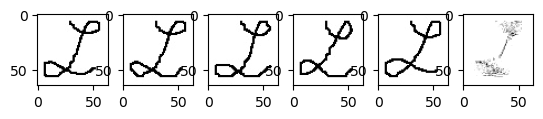

In [170]:
ga.plot()

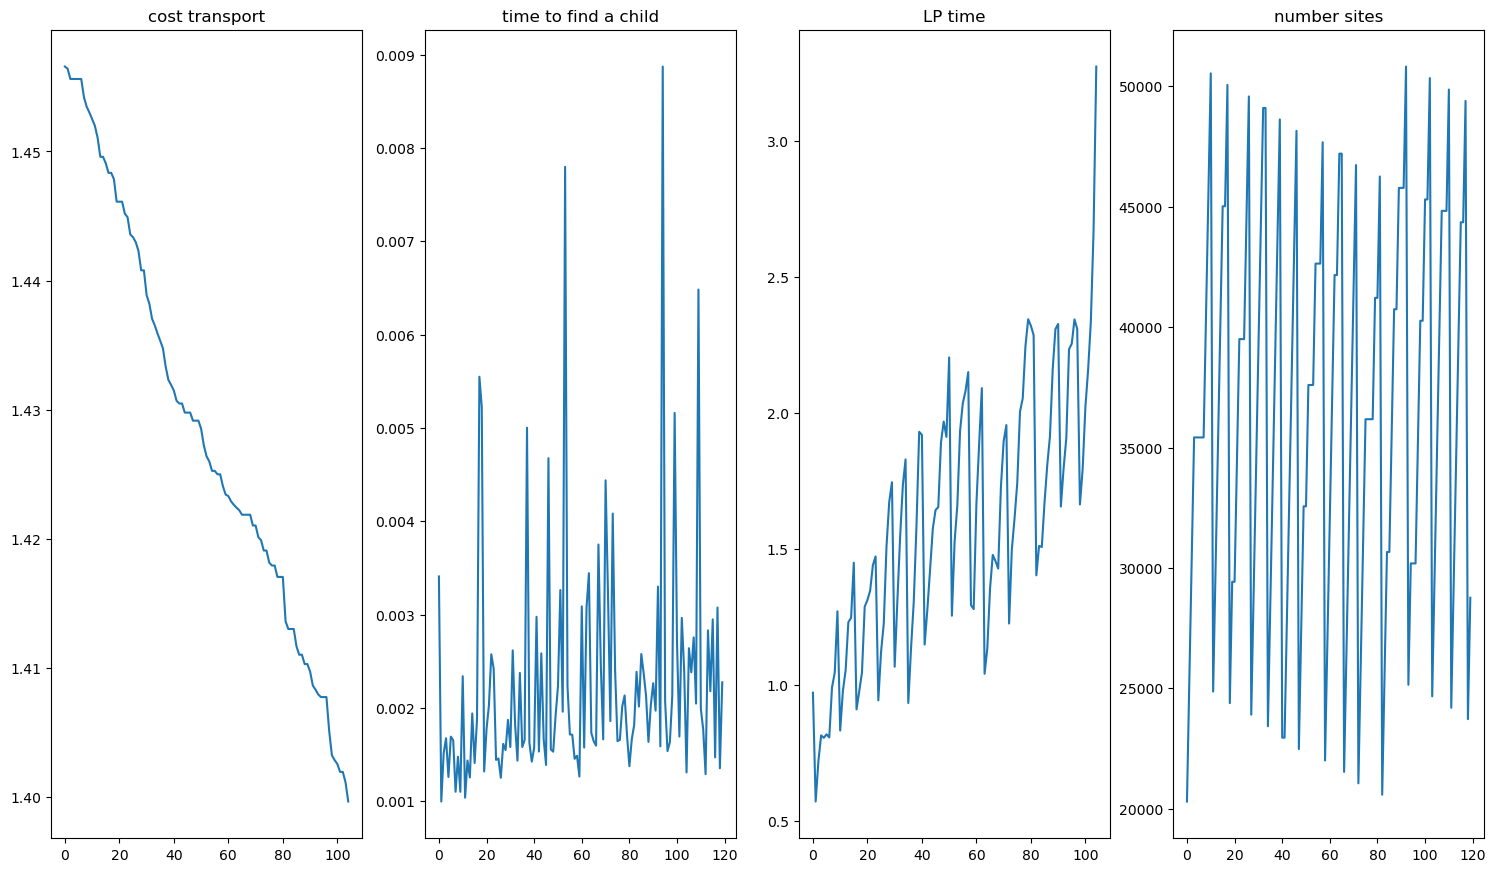

the final cost is 1.3996537526925237


In [171]:
figure, axis = plt.subplots(1, 4)

axis[0].plot(ga.cost)
axis[0].set_title("cost transport")
#axis[0].set_ylim((0, 2))

axis[1].plot(ga.time_child)
axis[1].set_title("time to find a child")
#axis[1].set_ylim((0, 0.01))
  
axis[2].plot(ga.time_model)
axis[2].set_title("LP time")
#axis[2].set_ylim((0, 0.5))

axis[3].plot(ga.n_children)
axis[3].set_title("number sites")

figure.set_size_inches(18.5, 10.5)

plt.show()

print(f"the final cost is {ga.cost[-1]}")

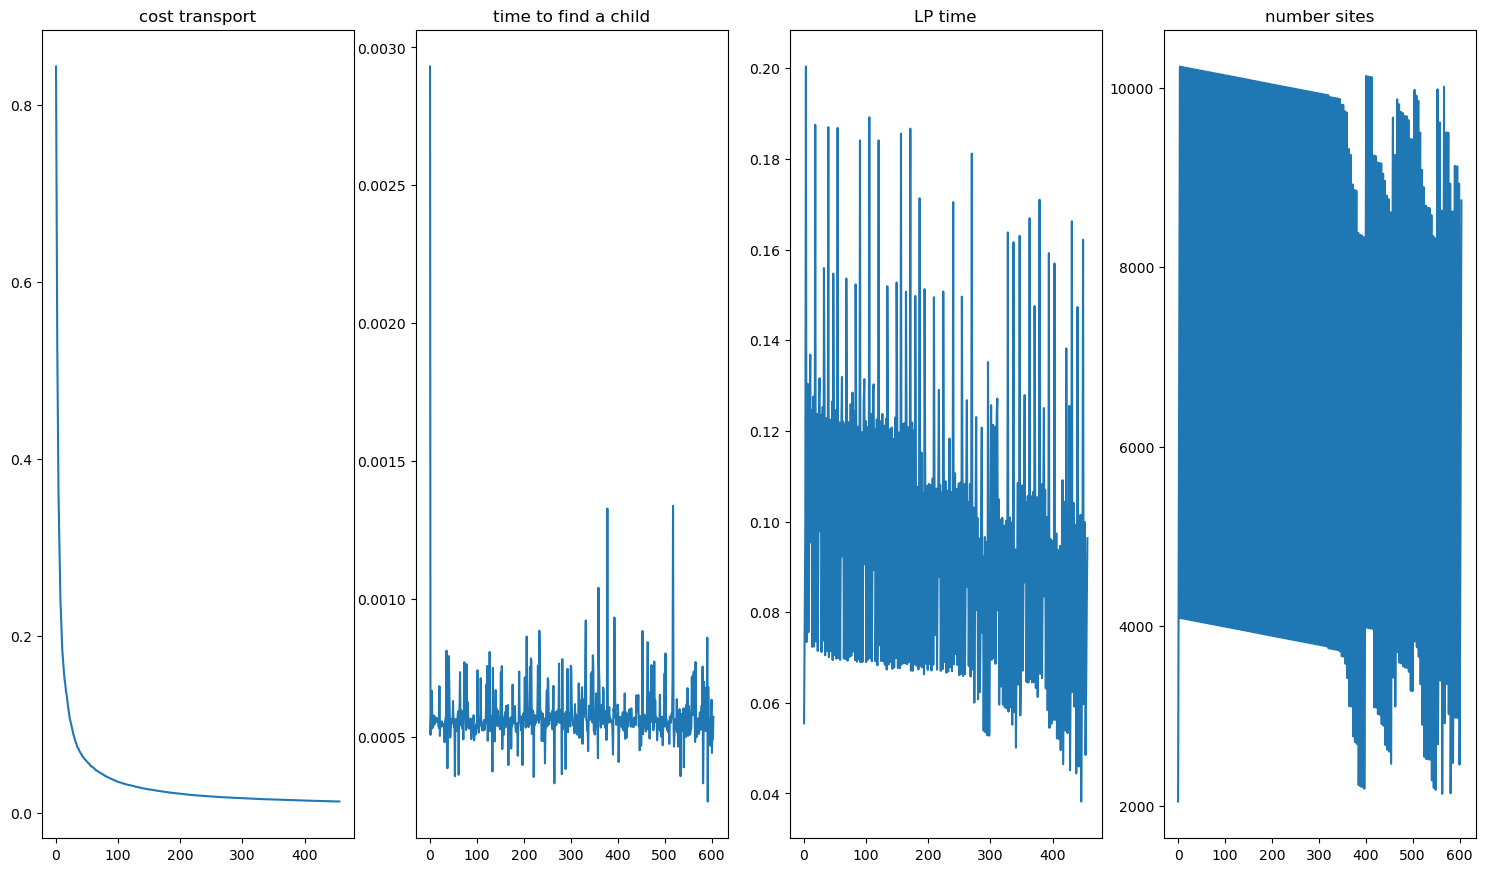

the final cost is 0.01250487168356236


In [127]:
figure, axis = plt.subplots(1, 4)

axis[0].plot(ga.cost)
axis[0].set_title("cost transport")
#axis[0].set_ylim((0, 2))

axis[1].plot(ga.time_child)
axis[1].set_title("time to find a child")
#axis[1].set_ylim((0, 0.01))
  
axis[2].plot(ga.time_model)
axis[2].set_title("LP time")
#axis[2].set_ylim((0, 0.5))

axis[3].plot(ga.n_children)
axis[3].set_title("number sites")

figure.set_size_inches(18.5, 10.5)

plt.show()

print(f"the final cost is {ga.cost[-1]}")

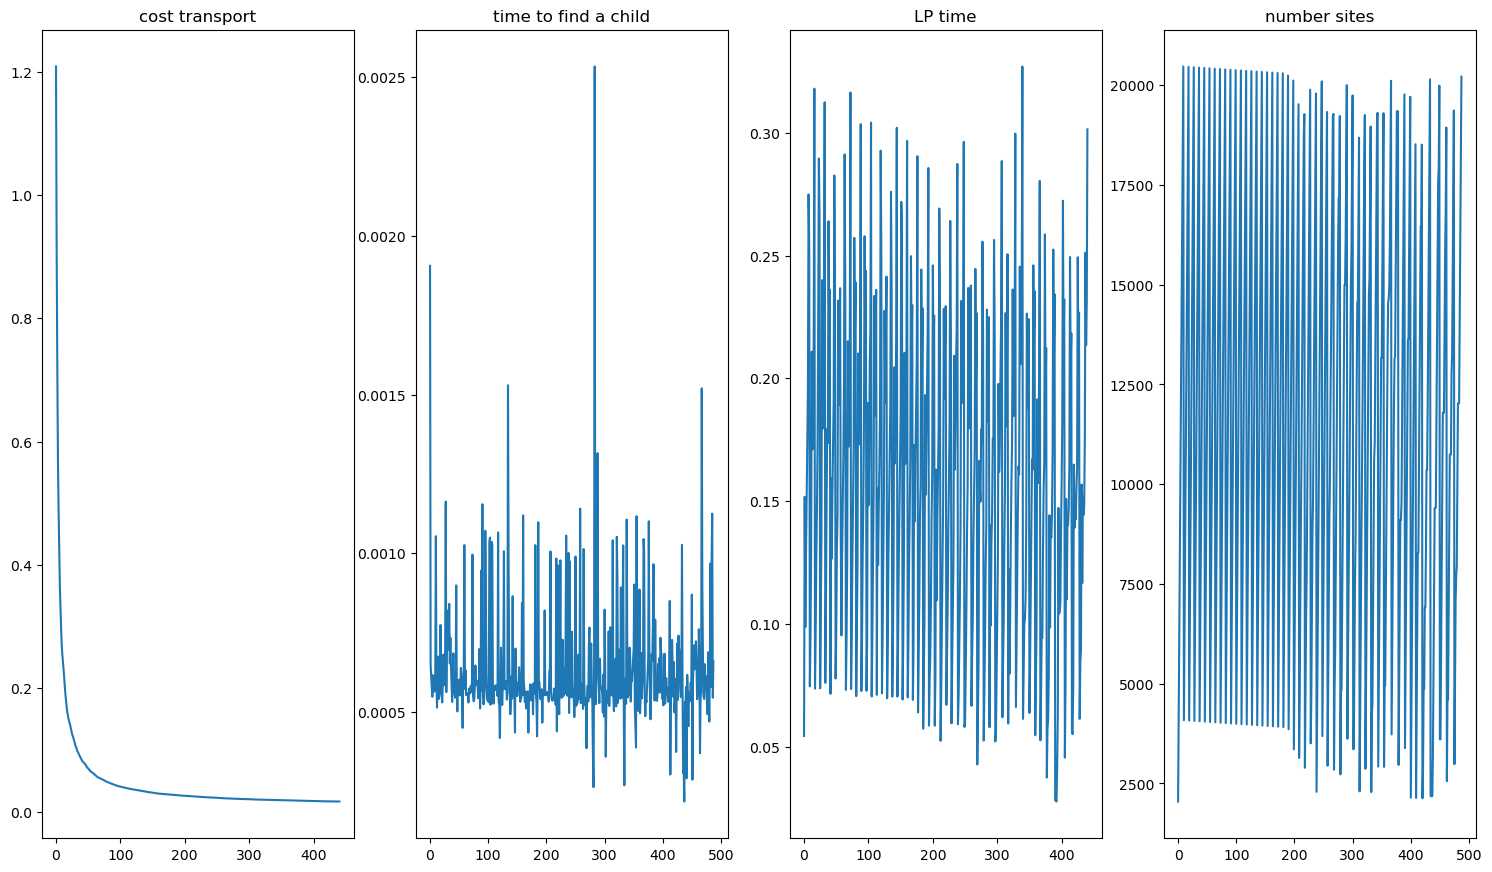

the final cost is 0.016378244729989545


In [131]:
figure, axis = plt.subplots(1, 4)

axis[0].plot(ga.cost)
axis[0].set_title("cost transport")
#axis[0].set_ylim((0, 2))

axis[1].plot(ga.time_child)
axis[1].set_title("time to find a child")
#axis[1].set_ylim((0, 0.01))
  
axis[2].plot(ga.time_model)
axis[2].set_title("LP time")
#axis[2].set_ylim((0, 0.5))

axis[3].plot(ga.n_children)
axis[3].set_title("number sites")

figure.set_size_inches(18.5, 10.5)

plt.show()

print(f"the final cost is {ga.cost[-1]}")